### K-Nearest-Neighbor (KNN) classification on Newsgroups 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
train_data = np.genfromtxt("newsgroups/trainMatrixModified.txt",delimiter="\t")
train_data = train_data.T
train_labels = np.genfromtxt("newsgroups/trainClasses.txt", delimiter = "\t" , usecols=(1), dtype=(int))
test_data = np.genfromtxt("newsgroups/testMatrixModified.txt",delimiter="\t")
test_data = test_data.T
test_labels = np.genfromtxt("newsgroups/testClasses.txt", delimiter = "\t", usecols=(1), dtype=(int))

In [2]:
from sklearn import preprocessing
from collections import Counter
import operator

def My_Knn_Classifer(x, data, labels, K, method):
    if method == 0:
        # Euclidean Distance
        dist = np.sqrt(((data - x)**2).sum(axis = 1))
    elif method == 1:
        # Cosine Distance
        norm_data = np.array([np.linalg.norm(data[i]) for i in range(len(data))])
        norm_x = np.linalg.norm(x)
        sim = np.dot(data,x)/(norm_data * norm_x)
        dist = 1 - sim
    ids = np.argsort(dist)
    k_neighbors = np.zeros((K,data.shape[1]))
    classCount={}
    for i in range(K):
        voteIlabel = labels[ids[i]]
        k_neighbors[i,:] = data[ids[i],:]
        classCount[voteIlabel] = classCount.get(voteIlabel,0) + 1
    sortedClassCount = sorted(classCount.iteritems(),key=operator.itemgetter(1), reverse=True)
    return k_neighbors, sortedClassCount[0][0]

In [3]:
def get_accuracy(tl, x, data, labels, K, method):
    lab_length = len(tl)
    error_count = 0.0
    for i in range(lab_length):
        ids, prediction = My_Knn_Classifer(x[i,:], data, labels, K, method)
        if (prediction != tl[i]): error_count += 1.0
    error = error_count/float(lab_length)
    return error

In [4]:
result = pd.DataFrame()
for i in range(0,20):
    result.loc[i,0] = i+1
    result.loc[i,1] = get_accuracy(test_labels, test_data, train_data, train_labels, i+1, 0)
    result.loc[i,2] =  get_accuracy(test_labels, test_data, train_data, train_labels, i+1, 1)
result.columns = ['K','Euclidean','Cosine']

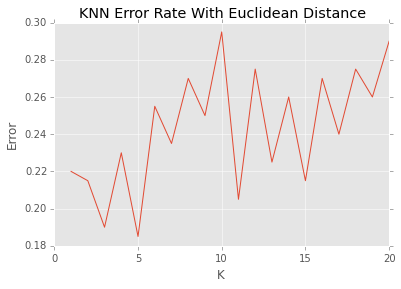

In [5]:
%matplotlib inline
plt.plot(result['K'], result['Euclidean'])
plt.title('KNN Error Rate With Euclidean Distance')
plt.xlabel('K')
plt.ylabel('Error')

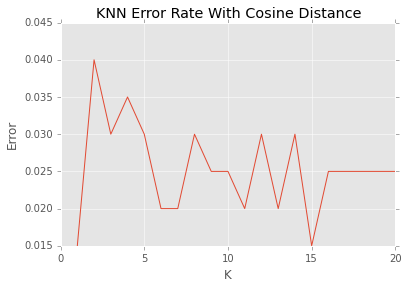

In [6]:
plt.plot(result['K'], result['Cosine'])
plt.title('KNN Error Rate With Cosine Distance')
plt.xlabel('K')
plt.ylabel('Error')

In [7]:
train_data.T.shape

(5500, 800)

In [8]:
test_data.T.shape

(5500, 200)

In [9]:
combined_data = np.concatenate((train_data.T, test_data.T), axis=1)
doc_freq = np.array([(combined_data!=0).sum(1)]).T
num_docs = len(combined_data[0,:])
mat = np.ones(np.shape(combined_data), dtype=float)*num_docs
idf = np.log2(np.divide(mat, doc_freq))
tfidf_data = combined_data * idf
new_data = tfidf_data.T

In [10]:
new_train = new_data[0:800,]
new_test = new_data[800:]

In [11]:
new_result = pd.DataFrame()
for i in range(0,20):
    new_result.loc[i,0] = i+1
    new_result.loc[i,1] = get_accuracy(test_labels, new_test, new_train, train_labels, i+1, 0)
    new_result.loc[i,2] =  get_accuracy(test_labels, new_test, new_train, train_labels, i+1, 1)
new_result.columns = ['K','Euclidean','Cosine']

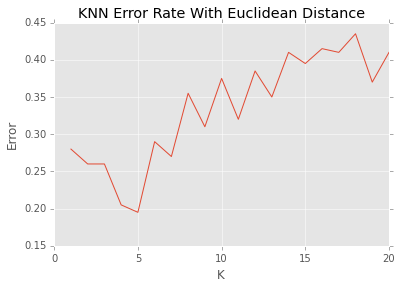

In [12]:
%matplotlib inline
plt.plot(new_result['K'], new_result['Euclidean'])
plt.title('KNN Error Rate With Euclidean Distance')
plt.xlabel('K')
plt.ylabel('Error')

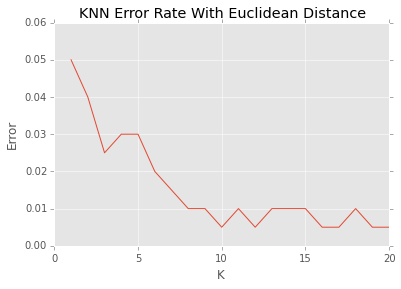

In [13]:
%matplotlib inline
plt.plot(new_result['K'], new_result['Cosine'])
plt.title('KNN Error Rate With Euclidean Distance')
plt.xlabel('K')
plt.ylabel('Error')

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
def Rocchio_classifier(x, data, labels):
    sim_0 = cosine_similarity(x, data[labels == 0,].sum(0))
    sim_1 = cosine_similarity(x, data[labels == 1,].sum(0))
    if sim_0 > sim_1:
        target = 1
    else: 
        target = 0
    return target,[sim_0, sim_1]

In [27]:
def Rocchio_accuracy(tl, x, data, labels):
    lab_length = len(tl)
    error_count = 0.0
    for i in range(lab_length):
        prediction, sim = Rocchio_classifier(x[i,:], data, labels)
        if (prediction != tl[i]): error_count += 1.0
    error = error_count/float(lab_length)
    return error

In [28]:
Rocchio_accuracy(test_labels, test_data, train_data, train_labels)

0.975

Euclidean similarity tends to have higher accuracy than cosine measure & normalizing the score. The best score was acheived in original data was with euclidean measure with k = 15. With weighted document frequency, we still have euclidean as our best measure around the same k.

### Classification using scikit-learn 

I have used the same dataset from the previous assingment.

In [21]:
bank_data = pd.read_csv('bank_numeric.csv', usecols=range(1,27))
bank_data_labels = bank_data['pep']
bank_data = bank_data.drop('pep', 1)
from sklearn.cross_validation import train_test_split
bank_train, bank_test, bank_target_train, bank_target_test = train_test_split(bank_data, bank_data_labels,
                                                                              test_size=0.2, random_state=33)

In [22]:
from sklearn import neighbors, tree, naive_bayes
from sklearn.metrics import classification_report, confusion_matrix
for i in range(1,7):
    n_neighbors = i
    knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
    knnclf.fit(bank_train, bank_target_train)
    knnpreds_test = knnclf.predict(bank_test)
    print(classification_report(bank_target_test, knnpreds_test))
    print(confusion_matrix(bank_target_test, knnpreds_test))

             precision    recall  f1-score   support

         NO       0.98      0.95      0.97        66
        YES       0.95      0.98      0.96        54

avg / total       0.97      0.97      0.97       120

[[63  3]
 [ 1 53]]
             precision    recall  f1-score   support

         NO       0.98      0.95      0.97        66
        YES       0.95      0.98      0.96        54

avg / total       0.97      0.97      0.97       120

[[63  3]
 [ 1 53]]
             precision    recall  f1-score   support

         NO       0.97      0.98      0.98        66
        YES       0.98      0.96      0.97        54

avg / total       0.98      0.97      0.97       120

[[65  1]
 [ 2 52]]
             precision    recall  f1-score   support

         NO       0.98      0.98      0.98        66
        YES       0.98      0.98      0.98        54

avg / total       0.98      0.98      0.98       120

[[65  1]
 [ 1 53]]
             precision    recall  f1-score   support

         N

The accuracy is somewhat same across different k values.

In [30]:
treeclf = tree.DecisionTreeClassifier()
treeclf = treeclf.fit(bank_train, bank_target_train)
treepreds_test = treeclf.predict(bank_test)
print(classification_report(bank_target_test, treepreds_test))
print(confusion_matrix(bank_target_test, treepreds_test))

             precision    recall  f1-score   support

         NO       1.00      1.00      1.00        66
        YES       1.00      1.00      1.00        54

avg / total       1.00      1.00      1.00       120

[[66  0]
 [ 0 54]]


In [31]:
nbclf = naive_bayes.GaussianNB()
nbclf = nbclf.fit(bank_train, bank_target_train)
nbpreds_test = nbclf.predict(bank_test)
print(classification_report(bank_target_test, nbpreds_test))
print(confusion_matrix(bank_target_test, nbpreds_test))

             precision    recall  f1-score   support

         NO       1.00      1.00      1.00        66
        YES       1.00      1.00      1.00        54

avg / total       1.00      1.00      1.00       120

[[66  0]
 [ 0 54]]


Both Naive Bayes and Decision Tree has near perfect accuray. Just because the accuracy is near perfect doesn't mean its good. I think since the data is too small, there may some kind of overfitting and judging by the performance results i beleive there is strong bias.

###  Data Analysis and Predictive Modeling on Census data

In [32]:
census_data = pd.read_csv("adult-modified.csv")

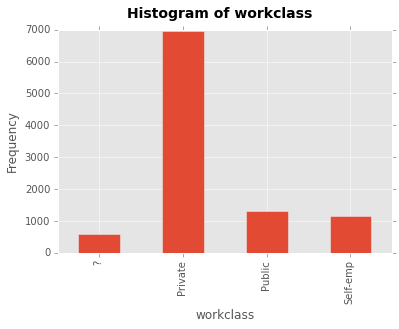

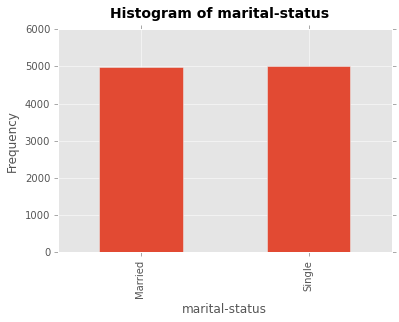

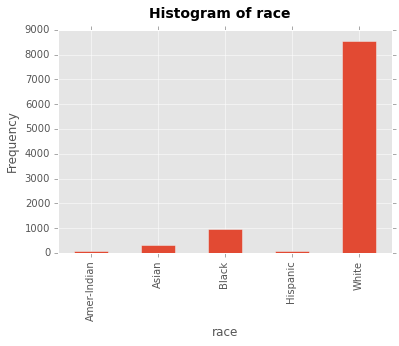

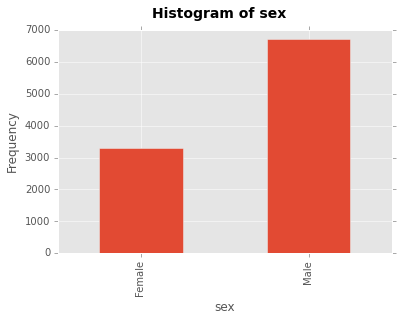

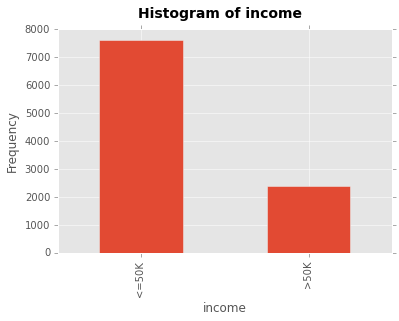

In [33]:
def plot_custom(col_name):
    fig = plt.figure()
    rgplot = census_data.groupby(col_name).size().plot(kind='bar')
    fig.suptitle('Histogram of ' + col_name, fontsize=14, fontweight='bold')
    rgplot.set_xlabel(col_name)
    rgplot.set_ylabel("Frequency")
    
for i in ['workclass','marital-status','race','sex','income']:
    plot_custom(i)

In [35]:
clean_data = census_data[census_data['workclass'] != '?']
clean_data['age'][clean_data['age'] == '?'] = clean_data['age'][clean_data['age'] != '?'].astype('int').mean()

/Users/akhil/.graphlab/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


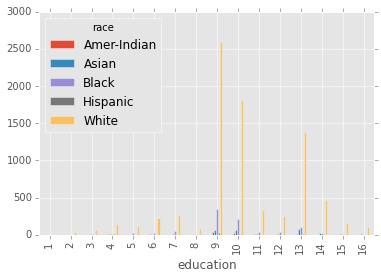

In [36]:
plt.show(pd.crosstab(clean_data['education'], clean_data['race']).plot(kind="bar"))

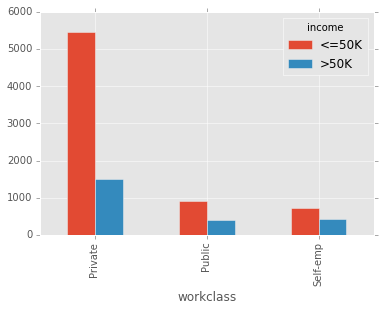

In [37]:
plt.show(pd.crosstab(clean_data['workclass'], clean_data['income']).plot(kind="bar"))

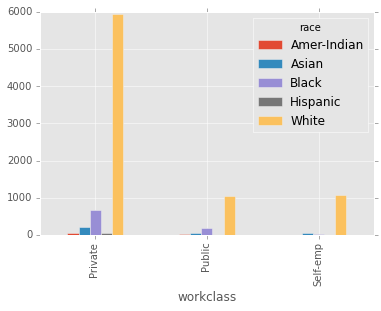

In [39]:
plt.show(pd.crosstab(clean_data['workclass'], clean_data['race']).plot(kind="bar"))

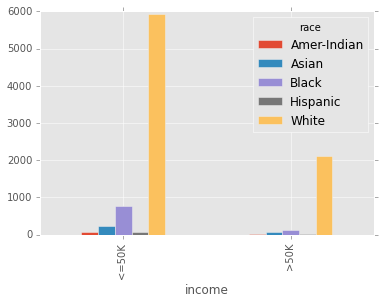

In [40]:
plt.show(pd.crosstab(clean_data['income'], clean_data['race']).plot(kind="bar"))

In [41]:
pd.crosstab(clean_data['income'], clean_data['race'])/clean_data.shape[0]

race,Amer-Indian,Asian,Black,Hispanic,White
income,,,,,
<=50K,0.008819,0.023799,0.082129,0.007331,0.631534
>50K,0.000956,0.007119,0.012643,0.000637,0.225032


In [42]:
clean_data.shape

(9412, 8)

In [43]:
def create_dummies(col_name,df):
    temp = pd.get_dummies(df[col_name])
    temp.columns = col_name+'_'+temp.columns.astype("str")
    return temp

new_data = pd.DataFrame()
new_data['age'] = clean_data['age']
new_data['age'] = new_data.age.astype("int")
new_data['hours-per-week'] = clean_data['hours-per-week']

for i in ['education','workclass','marital-status','race','sex']:
    ind_dummies = create_dummies(i, clean_data)
    new_data = pd.concat([ind_dummies, new_data], axis = 1)

In [45]:
from sklearn import neighbors, tree, naive_bayes
from sklearn import cross_validation
nbclf = naive_bayes.GaussianNB()
nbclf = nbclf.fit(new_data, clean_data['income'])
nbpreds_test = nbclf.predict(new_data)
cross_validation.cross_val_score(nbclf, new_data, clean_data['income'], cv = 10)

array([ 0.45010616,  0.43949045,  0.39384289,  0.46227418,  0.44420829,
        0.46014878,  0.46121148,  0.46758767,  0.44102019,  0.46276596])

In [46]:
from sklearn.lda import LDA
ldclf = LDA()
ldclf = ldclf.fit(new_data, clean_data['income'])
ldpreds_test = ldclf.predict(new_data)
print ldpreds_test
cross_validation.cross_val_score(ldclf, new_data, clean_data['income'], cv = 9)

['<=50K' '>50K' '<=50K' ..., '<=50K' '<=50K' '<=50K']


/Users/akhil/.graphlab/anaconda/lib/python2.7/site-packages/sklearn/lda.py:371: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


array([ 0.81279847,  0.78967495,  0.80592734,  0.82026769,  0.80210325,
        0.81166348,  0.82009569,  0.82870813,  0.82105263])

In [47]:
from sklearn import cross_validation
treeclf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=3)
treeclf = treeclf.fit(new_data, clean_data['income'])
treepreds_test = treeclf.predict(new_data)
print treepreds_test
cv_scores = cross_validation.cross_val_score(treeclf, new_data, clean_data['income'], cv=10)
cv_scores

['<=50K' '<=50K' '<=50K' ..., '<=50K' '<=50K' '<=50K']


array([ 0.77813163,  0.77707006,  0.77070064,  0.76408077,  0.76301807,
        0.75026567,  0.76726886,  0.78533475,  0.78214665,  0.77765957])

In [ ]:
from sklearn import tree
from StringIO import StringIO
tree.export_graphviz(treeclf,out_file='tree.dot')
## in terminal pass following command for a tree "dot -Tpng tree.dot -o tree.png "